# VAE Latent Risk Factor - Pipeline Dashboard

Central configuration and execution notebook for the full walk-forward validation pipeline.

**Workflow:**
1. Configure all parameters (Sections 1-2)
2. Load data (Section 3)
3. Run pipeline (Section 4)
4. Inspect results (Sections 5-7)

---
## 1. Setup

In [1]:
import os
import sys
import json
import logging
import tempfile
from dataclasses import replace, asdict
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Project root: go up from notebooks/ to project root
_NB_DIR = Path(os.path.abspath("")).resolve()
PROJECT_ROOT = (_NB_DIR / "..").resolve() if _NB_DIR.name == "notebooks" else _NB_DIR
os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT))

from src.config import (
    PipelineConfig,
    DataPipelineConfig,
    VAEArchitectureConfig,
    LossConfig,
    TrainingConfig,
    InferenceConfig,
    RiskModelConfig,
    PortfolioConfig,
    WalkForwardConfig,
)
from src.data_pipeline.data_loader import generate_synthetic_csv, load_stock_data
from src.data_pipeline.returns import compute_log_returns
from src.data_pipeline.features import compute_trailing_volatility
from src.integration.pipeline import FullPipeline
from src.integration.reporting import format_summary_table, serialize_for_json
from src.integration.visualization import (
    plot_fold_metrics,
    plot_e_star_distribution,
    plot_pairwise_heatmap,
    style_summary_table,
    style_fold_table,
)
from src.utils import get_optimal_device
from src.walk_forward.selection import aggregate_fold_metrics, summary_statistics

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s: %(message)s")
logger = logging.getLogger("dashboard")

print(f"PyTorch {torch.__version__} | Device: {get_optimal_device()}")
print(f"Working directory: {os.getcwd()}")

/Users/mathis/Latent_risk_factor/Latent_risk_factor/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-07 15:44:57,696 [INFO] src.utils: Device auto-detected: MPS (Apple Silicon)


PyTorch 2.10.0 | Device: mps
Working directory: /Users/mathis/Latent_risk_factor/Latent_risk_factor


---
## 2. Configuration

Two configuration profiles are available. **Run ONLY one section:**
- **Section 2a** — Synthetic data: minimal parameters for quick end-to-end testing
- **Section 2b** — Real data: full production configuration

Always run the **Global** cell (below) first, then choose ONE section.

In [2]:
# ============================================================
# GLOBAL
# ============================================================
SEED = 42
DEVICE = str(get_optimal_device())

USE_SYNTHETIC = True
QUICK_MODE = False  # Set True for minimal config even with real data

2026-02-07 15:44:57,702 [INFO] src.utils: Device auto-detected: MPS (Apple Silicon)


### 2a. Synthetic Data (Quick Test)

Run **only this cell** to configure the pipeline for a minimal end-to-end test on synthetic data. Skip Section 2b entirely.

In [3]:
# ============================================================
# SYNTHETIC — Minimal config for end-to-end testing
# Run ONLY this cell, then jump to Section 3
# ============================================================

if USE_SYNTHETIC:
    QUICK_MODE = True  # Always True for synthetic data
    DATA_PATH = ""
    N_STOCKS = 10
    N_YEARS = 6

    # K=10 for speed; r_max relaxed because C_L floor (384) makes the CNN
    # too large for small synthetic universes — acceptable for testing only.
    config = PipelineConfig(
        data=DataPipelineConfig(
            n_stocks=N_STOCKS,
            window_length=504,
            n_features=2,
        ),
        vae=VAEArchitectureConfig(
            K=10,
            window_length=504,
            n_features=2,
            r_max=1e6,
        ),
        loss=LossConfig(mode="P"),
        training=TrainingConfig(
            max_epochs=1,
            batch_size=256,
            learning_rate=1e-4,
            patience=1,
        ),
        inference=InferenceConfig(),
        risk_model=RiskModelConfig(),
        portfolio=PortfolioConfig(n_starts=2),
        walk_forward=WalkForwardConfig(
            total_years=N_YEARS,
            min_training_years=max(3, N_YEARS // 3),
            holdout_years=max(1, N_YEARS // 5),
        ),
        seed=SEED,
    )

    HP_GRID = [{"mode": "P", "learning_rate": 1e-4, "alpha": 1.0}]

    print(f"[Synthetic mode] {N_STOCKS} stocks, {N_YEARS} years, K={config.vae.K}")
    print(f"  max_epochs={config.training.max_epochs}, patience={config.training.patience}, HP_GRID=1 config, n_starts=2")
    print(f"  r_max={config.vae.r_max:.0e} (relaxed for testing)")
    print(f"  Walk-forward: {config.walk_forward.total_years}y total, "
        f"{config.walk_forward.min_training_years}y min training, "
        f"{config.walk_forward.holdout_years}y holdout")
    print(f"  Device: {DEVICE}")

[Synthetic mode] 10 stocks, 6 years, K=10
  max_epochs=1, patience=1, HP_GRID=1 config, n_starts=2
  r_max=1e+06 (relaxed for testing)
  Walk-forward: 6y total, 3y min training, 1y holdout
  Device: mps


### 2b. Real Data (Production)

Run **all cells below** (through "ASSEMBLE FULL CONFIG") for full production configuration. Skip Section 2a.

In [4]:
# ============================================================
# DATA SOURCE — Real data
# ============================================================
DATA_PATH = "data/stock_data.csv"  # <-- Set path to your stock data CSV

# Synthetic parameters (unused when USE_SYNTHETIC=False)
N_STOCKS = 50
N_YEARS = 10

In [5]:
# ============================================================
# DATA PIPELINE (MOD-001)
# ============================================================
data_cfg = DataPipelineConfig(
    n_stocks=1000,               # universe cap (max stocks)
    window_length=504,           # T: sliding window length (trading days)
    n_features=2,                # F: features per timestep (return + realized vol)
    vol_window=252,              # trailing vol lookback (days)
    vix_lookback_percentile=80.0,# VIX percentile for crisis threshold
    min_valid_fraction=0.80,     # minimum valid data fraction per stock
)

In [6]:
# ============================================================
# VAE ARCHITECTURE (MOD-002)
# ============================================================
vae_cfg = VAEArchitectureConfig(
    K=200,                       # latent capacity ceiling
    sigma_sq_init=1.0,           # initial observation noise
    sigma_sq_min=1e-4,           # lower clamp for sigma^2
    sigma_sq_max=10.0,           # upper clamp for sigma^2
    window_length=504,           # T (must match data_cfg)
    n_features=2,                # F (must match data_cfg)
    r_max=5.0,                   # max parameter/data ratio (relaxed for synthetic)
)

print(f"Encoder depth L={vae_cfg.encoder_depth}, "
      f"Final width C_L={vae_cfg.final_layer_width}, "
      f"D={vae_cfg.D}")

Encoder depth L=5, Final width C_L=520, D=1008


In [7]:
# ============================================================
# LOSS FUNCTION (MOD-004)
# ============================================================
loss_cfg = LossConfig(
    mode="P",                    # 'P' (primary), 'F' (fallback), 'A' (advanced)
    gamma=3.0,                   # crisis overweighting factor
    lambda_co_max=0.5,           # max co-movement loss weight
    beta_fixed=1.0,              # fixed beta for Mode A
    warmup_fraction=0.20,        # fraction of epochs for Mode F warmup
    max_pairs=2048,              # max pairs for co-movement loss
    delta_sync=21,               # max date gap for synchronization (days)
)

In [8]:
# ============================================================
# TRAINING (MOD-005)
# ============================================================
training_cfg = TrainingConfig(
    max_epochs=100,              # maximum training epochs
    batch_size=256,              # batch size
    learning_rate=1e-4,          # initial learning rate (eta_0)
    weight_decay=1e-5,           # Adam weight decay
    adam_betas=(0.9, 0.999),     # Adam betas
    adam_eps=1e-8,               # Adam epsilon
    patience=10,                 # early stopping patience (epochs)
    lr_patience=5,               # ReduceLROnPlateau patience
    lr_factor=0.5,               # ReduceLROnPlateau factor
    n_strata=15,                 # strata for synchronous batching
    curriculum_phase1_frac=0.30, # fraction of epochs: sync+stratified batching
    curriculum_phase2_frac=0.30, # fraction of epochs: + co-movement loss ramp
)

In [9]:
# ============================================================
# INFERENCE (MOD-006)
# ============================================================
inference_cfg = InferenceConfig(
    batch_size=512,              # inference batch size
    au_threshold=0.01,           # KL threshold for active unit (nats)
    r_min=2,                     # min observations-per-parameter for AU_max
    aggregation_method="mean",   # profile aggregation method
)

In [10]:
# ============================================================
# RISK MODEL (MOD-007)
# ============================================================
risk_model_cfg = RiskModelConfig(
    winsorize_lo=5.0,            # lower percentile for vol ratio winsorization
    winsorize_hi=95.0,           # upper percentile
    d_eps_floor=1e-6,            # floor for idiosyncratic variance
    conditioning_threshold=1e6,  # condition number threshold for ridge fallback
    ridge_scale=1e-6,            # ridge regularization scale
)

In [11]:
# ============================================================
# PORTFOLIO OPTIMIZATION (MOD-008)
# Constraints identical for VAE and all 6 benchmarks (INV-012)
# ============================================================
portfolio_cfg = PortfolioConfig(
    lambda_risk=1.0,             # risk aversion
    w_max=0.05,                  # max weight per stock (hard cap)
    w_min=0.001,                 # min active weight (semi-continuous)
    w_bar=0.03,                  # concentration penalty threshold
    phi=25.0,                    # concentration penalty weight
    kappa_1=0.1,                 # linear turnover penalty
    kappa_2=7.5,                 # quadratic turnover penalty
    delta_bar=0.01,              # turnover penalty threshold
    tau_max=0.30,                # max one-way turnover (hard cap)
    n_starts=5,                  # multi-start initializations
    sca_max_iter=100,            # max SCA iterations
    sca_tol=1e-8,               # SCA convergence tolerance
    armijo_c=1e-4,               # Armijo sufficient decrease
    armijo_rho=0.5,              # Armijo backtracking factor
    armijo_max_iter=20,          # max Armijo backtracking steps
    max_cardinality_elim=100,    # max cardinality elimination rounds
    entropy_eps=1e-30,           # numerical stability for log()
    alpha_grid=[0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0],  # frontier alpha grid
)

In [12]:
# ============================================================
# WALK-FORWARD VALIDATION (MOD-009)
# ============================================================
walk_forward_cfg = WalkForwardConfig(
    total_years=30,              # total history length
    min_training_years=10,       # minimum training window
    oos_months=6,                # out-of-sample period (months)
    embargo_days=21,             # embargo between train and OOS (trading days)
    holdout_years=3,             # final holdout period
    val_years=2,                 # nested validation for Phase A
    score_lambda_pen=5.0,        # MDD penalty weight in composite score
    score_lambda_est=2.0,        # estimation quality penalty weight
    score_mdd_threshold=0.20,    # MDD threshold in composite score
)

In [13]:
# ============================================================
# HP GRID for Phase A (set to None for default 18-config grid)
# ============================================================
HP_GRID = None  # None = default: 3 modes x 2 LRs x 3 alphas = 18 configs

# Uncomment to define a custom grid:
# HP_GRID = [
#     {"mode": "P", "learning_rate": 5e-4, "alpha": 1.0},
#     {"mode": "F", "learning_rate": 1e-3, "alpha": 0.5},
#     {"mode": "A", "learning_rate": 1e-3, "alpha": 2.0},
# ]

In [14]:
# ============================================================
# ASSEMBLE FULL CONFIG
# ============================================================
if not USE_SYNTHETIC:
      config = PipelineConfig(
            data=data_cfg,
            vae=vae_cfg,
            loss=loss_cfg,
            training=training_cfg,
            inference=inference_cfg,
            risk_model=risk_model_cfg,
            portfolio=portfolio_cfg,
            walk_forward=walk_forward_cfg,
            seed=SEED,
      )

      print("PipelineConfig assembled.")
      print(f"  Walk-forward: {config.walk_forward.total_years}y total, "
            f"{config.walk_forward.min_training_years}y min training, "
            f"{config.walk_forward.holdout_years}y holdout")
      print(f"  VAE: K={config.vae.K}, T={config.vae.window_length}, F={config.vae.n_features}")
      print(f"  Training: {config.training.max_epochs} max epochs, "
            f"bs={config.training.batch_size}, lr={config.training.learning_rate}")
      print(f"  Loss mode: {config.loss.mode}, gamma={config.loss.gamma}")
      print(f"  Capacity guard r_max: {config.vae.r_max}")
      print(f"  Device: {DEVICE}")

In [15]:
# ============================================================
# QUICK_MODE override for real data
# When QUICK_MODE=True on real data, apply the same minimal
# config as the synthetic path for fast end-to-end testing.
# ============================================================
if QUICK_MODE and not USE_SYNTHETIC:
    config = replace(config,
        vae=replace(config.vae, K=10, r_max=1e6),
        training=replace(config.training, max_epochs=1, patience=1, batch_size=256, learning_rate=1e-4),
        portfolio=replace(config.portfolio, n_starts=2),
    )
    HP_GRID = [{"mode": "P", "learning_rate": 1e-4, "alpha": 1.0}]
    print("[QUICK MODE] Minimal config applied to real data")
    print(f"  K={config.vae.K}, max_epochs={config.training.max_epochs}, "
          f"patience={config.training.patience}, n_starts={config.portfolio.n_starts}")
    print(f"  HP_GRID=1 config, r_max={config.vae.r_max:.0e}")

---
## 3. Data Loading

In [16]:
np.random.seed(SEED)

if USE_SYNTHETIC:
    start_year = 2000
    end_year = start_year + N_YEARS
    start_date = f"{start_year}-01-03"

    with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as f:
        csv_path = f.name

    generate_synthetic_csv(
        csv_path,
        n_stocks=N_STOCKS,
        start_date=start_date,
        end_date=f"{end_year}-12-31",
        seed=SEED,
    )
    stock_data = load_stock_data(csv_path)
    os.unlink(csv_path)
    print(f"Synthetic data: {N_STOCKS} stocks, {start_date} to {end_year}-12-31")
else:
    stock_data = load_stock_data(DATA_PATH)
    start_date = str(stock_data["date"].min().date())
    print(f"Loaded data from {DATA_PATH}")

print(f"Stock data shape: {stock_data.shape}")
print(f"Date range: {stock_data['date'].min()} to {stock_data['date'].max()}")
print(f"Unique stocks: {stock_data['permno'].nunique()}")
stock_data.head()

Synthetic data: 50 stocks, 2000-01-03 to 2010-12-31
Stock data shape: (130760, 8)
Date range: 2000-01-03 00:00:00 to 2010-12-31 00:00:00
Unique stocks: 50


,permno,date,adj_price,volume,exchange_code,share_code,market_cap,delisting_return
0,10001,2000-01-03,16.661260,4918674,2,10,7.581711e+09,NaN
1,10001,2000-01-04,16.046207,2160301,2,10,7.301831e+09,NaN
2,10001,2000-01-05,15.938339,12756354,2,10,7.252746e+09,NaN
3,10001,2000-01-06,16.511826,9089030,2,10,7.513711e+09,NaN
4,10001,2000-01-07,16.030466,2057322,2,10,7.294668e+09,NaN


In [17]:
# Compute log-returns and trailing volatility
returns = compute_log_returns(stock_data)
trailing_vol = compute_trailing_volatility(returns, window=config.data.vol_window)

print(f"Returns: {returns.shape[0]} dates x {returns.shape[1]} stocks")
print(f"Trailing vol: {trailing_vol.shape} (first {config.data.vol_window-1} rows NaN)")
print(f"Returns date range: {returns.index[0]} to {returns.index[-1]}")

Returns: 2870 dates x 50 stocks
Trailing vol: (2870, 50) (first 251 rows NaN)
Returns date range: 2000-01-03 00:00:00 to 2010-12-31 00:00:00


---
## 4. Run Pipeline

Executes the full walk-forward validation: Phase A (HP selection) + Phase B (deployment) on each fold, then benchmarks, statistical tests, and report generation.

In [18]:
pipeline = FullPipeline(config)

results = pipeline.run(
    stock_data=stock_data,
    returns=returns,
    trailing_vol=trailing_vol,
    skip_phase_a=USE_SYNTHETIC,
    vix_data=None,
    start_date=start_date,
    hp_grid=HP_GRID,
    device=DEVICE,
)

print("Pipeline complete.")
print(f"Folds processed: {len(results['vae_results'])}")
print(f"Benchmarks: {list(results['benchmark_results'].keys())}")

2026-02-07 15:44:59,634 [INFO] src.integration.pipeline: Starting walk-forward: 4 folds + holdout
2026-02-07 15:44:59,635 [INFO] src.integration.pipeline: [Fold 0/4] Phase A skipped, using default config
2026-02-07 15:44:59,635 [INFO] src.integration.pipeline: [Fold 0/4] Phase B: deployment training
2026-02-07 15:45:00,005 [INFO] src.integration.pipeline:   [Fold 0] Windowing: 14100 windows from 50 stocks, 785 train days
    Training: 100%|██████████| 50/50 [02:27<00:00,  2.94s/step, AU=10, epoch=1/1, loss=555.1682, lr=1.0e-04, val=507.5042]
2026-02-07 15:47:28,692 [INFO] src.integration.pipeline:   [Fold 0] Training: 1 epochs in 149.1s (best_epoch=0)
2026-02-07 15:47:28,693 [INFO] src.integration.pipeline:   [Fold 0] Inference: extracting latent profiles...
    Inference: 100%|██████████| 28/28 [00:16<00:00,  1.66batch/s]
/Users/mathis/Latent_risk_factor/Latent_risk_factor/src/benchmarks/erc.py:67: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver setti

Pipeline complete.
Folds processed: 5
Benchmarks: ['equal_weight', 'inverse_vol', 'min_variance', 'erc', 'pca_factor_rp', 'pca_vol']


---
## 5. Results - Summary Report

In [19]:
# Text summary
print(format_summary_table(results["report"]))

VAE LATENT RISK FACTOR — RESULTS REPORT

Scenario: C
Recommendation: Adopt PCA (cost /100)

E* epochs: mean=1.0, std=0.0, range=[1, 1]

Statistical Tests (0 comparisons, alpha=0.05):
--------------------------------------------------

  vs equal_weight:
    ann_vol_oos: skipped (Too few paired observations (4))
    max_drawdown_oos: skipped (Too few paired observations (4))
    sharpe: skipped (Too few paired observations (4))

  vs inverse_vol:
    ann_vol_oos: skipped (Too few paired observations (4))
    max_drawdown_oos: skipped (Too few paired observations (4))
    sharpe: skipped (Too few paired observations (4))

  vs min_variance:
    ann_vol_oos: skipped (Too few paired observations (4))
    max_drawdown_oos: skipped (Too few paired observations (4))
    sharpe: skipped (Too few paired observations (4))

  vs erc:
    ann_vol_oos: skipped (Too few paired observations (4))
    max_drawdown_oos: skipped (Too few paired observations (4))
    sharpe: skipped (Too few paired observ

In [20]:
# Deployment recommendation
deployment = results["report"]["deployment"]
print(f"Scenario: {deployment['scenario']}")
print(f"Recommendation: {deployment['recommendation']}")
print()
print("Per-benchmark wins (VAE vs benchmark on primary metrics):")
for bench, info in deployment["per_benchmark"].items():
    print(f"  {bench:20s}: {info['wins']}/{info['total']} metrics won")

Scenario: C
Recommendation: Adopt PCA (cost /100)

Per-benchmark wins (VAE vs benchmark on primary metrics):
  equal_weight        : 0/4 metrics won
  inverse_vol         : 0/4 metrics won
  min_variance        : 0/4 metrics won
  erc                 : 0/4 metrics won
  pca_factor_rp       : 0/4 metrics won
  pca_vol             : 0/4 metrics won


In [21]:
# VAE summary statistics
vae_df = aggregate_fold_metrics(results["vae_results"])
vae_summary = summary_statistics(vae_df)
print("VAE Summary Statistics:")
style_summary_table(vae_summary)

VAE Summary Statistics:


,metric,mean,median,std,min,max,count
0,fold_id,2.0000,2.0000,1.5811,0.0000,4.0000,5.0000
1,H_norm_oos,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000
2,ann_vol_oos,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000
3,max_drawdown_oos,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000
4,sharpe,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000
5,AU,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000
6,e_star,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000
7,error,1.0000,1.0000,0.0000,1.0000,1.0000,5.0000


In [22]:
# Benchmark summary statistics
for bench_name, bench_metrics in results["benchmark_results"].items():
    bench_df = aggregate_fold_metrics(bench_metrics)
    bench_summary = summary_statistics(bench_df)
    print(f"\n{bench_name} Summary:")
    display(style_summary_table(bench_summary))


equal_weight Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.0766,0.0914,0.0942,-0.0351,0.1589,4.0000
1,ann_vol_oos,0.0436,0.0433,0.0041,0.0390,0.0488,4.0000
2,sharpe,1.8669,2.0952,2.3220,-0.7993,4.0763,4.0000
3,max_drawdown_oos,0.0336,0.0313,0.0267,0.0083,0.0634,4.0000
4,calmar,5.9470,0.5133,8.7712,-0.7214,19.1841,5.0000
5,eff_n_positions,50.0000,50.0000,0.0000,50.0000,50.0000,5.0000
6,fold_id,2.0000,2.0000,1.5811,0.0000,4.0000,5.0000



inverse_vol Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.0892,0.0937,0.0428,0.0424,0.1271,4.0000
1,ann_vol_oos,0.0306,0.0303,0.0021,0.0283,0.0334,4.0000
2,sharpe,2.9715,3.0541,1.5473,1.3924,4.3857,4.0000
3,max_drawdown_oos,0.0213,0.0226,0.0152,0.0055,0.0344,4.0000
4,calmar,7.4704,1.8509,9.6792,0.0000,22.6872,5.0000
5,eff_n_positions,37.7103,37.6995,0.0417,37.6623,37.7696,5.0000
6,fold_id,2.0000,2.0000,1.5811,0.0000,4.0000,5.0000



min_variance Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.0900,0.0932,0.0224,0.0630,0.1108,4.0000
1,ann_vol_oos,0.0281,0.0275,0.0016,0.0268,0.0305,4.0000
2,sharpe,3.2307,3.2951,0.9055,2.2726,4.0600,4.0000
3,max_drawdown_oos,0.0162,0.0155,0.0106,0.0051,0.0288,4.0000
4,calmar,7.5307,3.8683,8.4283,0.0000,20.7361,5.0000
5,eff_n_positions,29.9601,29.8873,0.4349,29.5091,30.5118,5.0000
6,fold_id,2.0000,2.0000,1.5811,0.0000,4.0000,5.0000



erc Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.0853,0.0937,0.0506,0.0245,0.1294,4.0000
1,ann_vol_oos,0.0326,0.0323,0.0023,0.0304,0.0356,4.0000
2,sharpe,2.6780,2.8544,1.7043,0.7402,4.2631,4.0000
3,max_drawdown_oos,0.0228,0.0239,0.0163,0.0060,0.0373,4.0000
4,calmar,6.9736,1.7356,9.3202,0.0000,21.7062,5.0000
5,eff_n_positions,41.5690,41.6122,0.6559,40.7173,42.2999,5.0000
6,fold_id,2.0000,2.0000,1.5811,0.0000,4.0000,5.0000



pca_factor_rp Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.0942,0.0974,0.0423,0.0474,0.1344,4.0000
1,ann_vol_oos,0.0326,0.0324,0.0023,0.0301,0.0356,4.0000
2,sharpe,2.9478,2.9379,1.4721,1.4444,4.4710,4.0000
3,max_drawdown_oos,0.0231,0.0236,0.0164,0.0054,0.0399,4.0000
4,calmar,7.4788,2.0661,10.3601,0.0000,24.8337,5.0000
5,eff_n_positions,40.9402,40.9948,0.2632,40.5714,41.2268,5.0000
6,fold_id,2.0000,2.0000,1.5811,0.0000,4.0000,5.0000



pca_vol Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.0730,0.0616,0.0956,-0.0166,0.1856,4.0000
1,ann_vol_oos,0.0449,0.0442,0.0031,0.0420,0.0492,4.0000
2,sharpe,1.7110,1.3996,2.2540,-0.3727,4.4172,4.0000
3,max_drawdown_oos,0.0346,0.0316,0.0248,0.0107,0.0644,4.0000
4,calmar,4.7321,0.0758,7.6512,-0.3687,17.4129,5.0000
5,eff_n_positions,41.2196,41.2239,0.2256,40.9863,41.5116,5.0000
6,fold_id,2.0000,2.0000,1.5811,0.0000,4.0000,5.0000


---
## 6. Results - Per-Fold Detail

In [23]:
# VAE per-fold metrics
print("VAE Per-Fold Metrics:")
style_fold_table(vae_df)

VAE Per-Fold Metrics:


,fold_id,H_norm_oos,ann_vol_oos,max_drawdown_oos,sharpe,AU,e_star,error
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
4,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


E* epochs: mean=1.0, std=0.0, range=[1, 1]


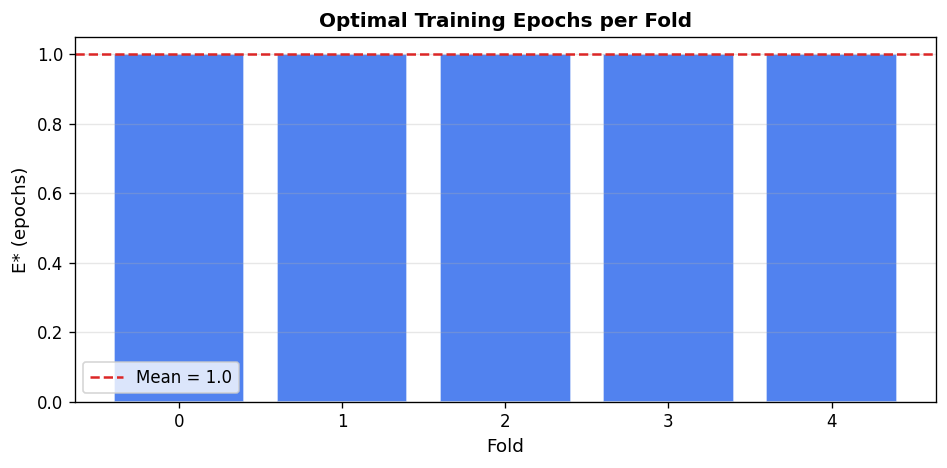

In [24]:
# E* distribution
e_star_summary = results["report"]["e_star_summary"]
print(f"E* epochs: mean={e_star_summary['mean']:.1f}, "
      f"std={e_star_summary['std']:.1f}, "
      f"range=[{e_star_summary['min']}, {e_star_summary['max']}]")

plot_e_star_distribution(results["e_stars"])
plt.show()

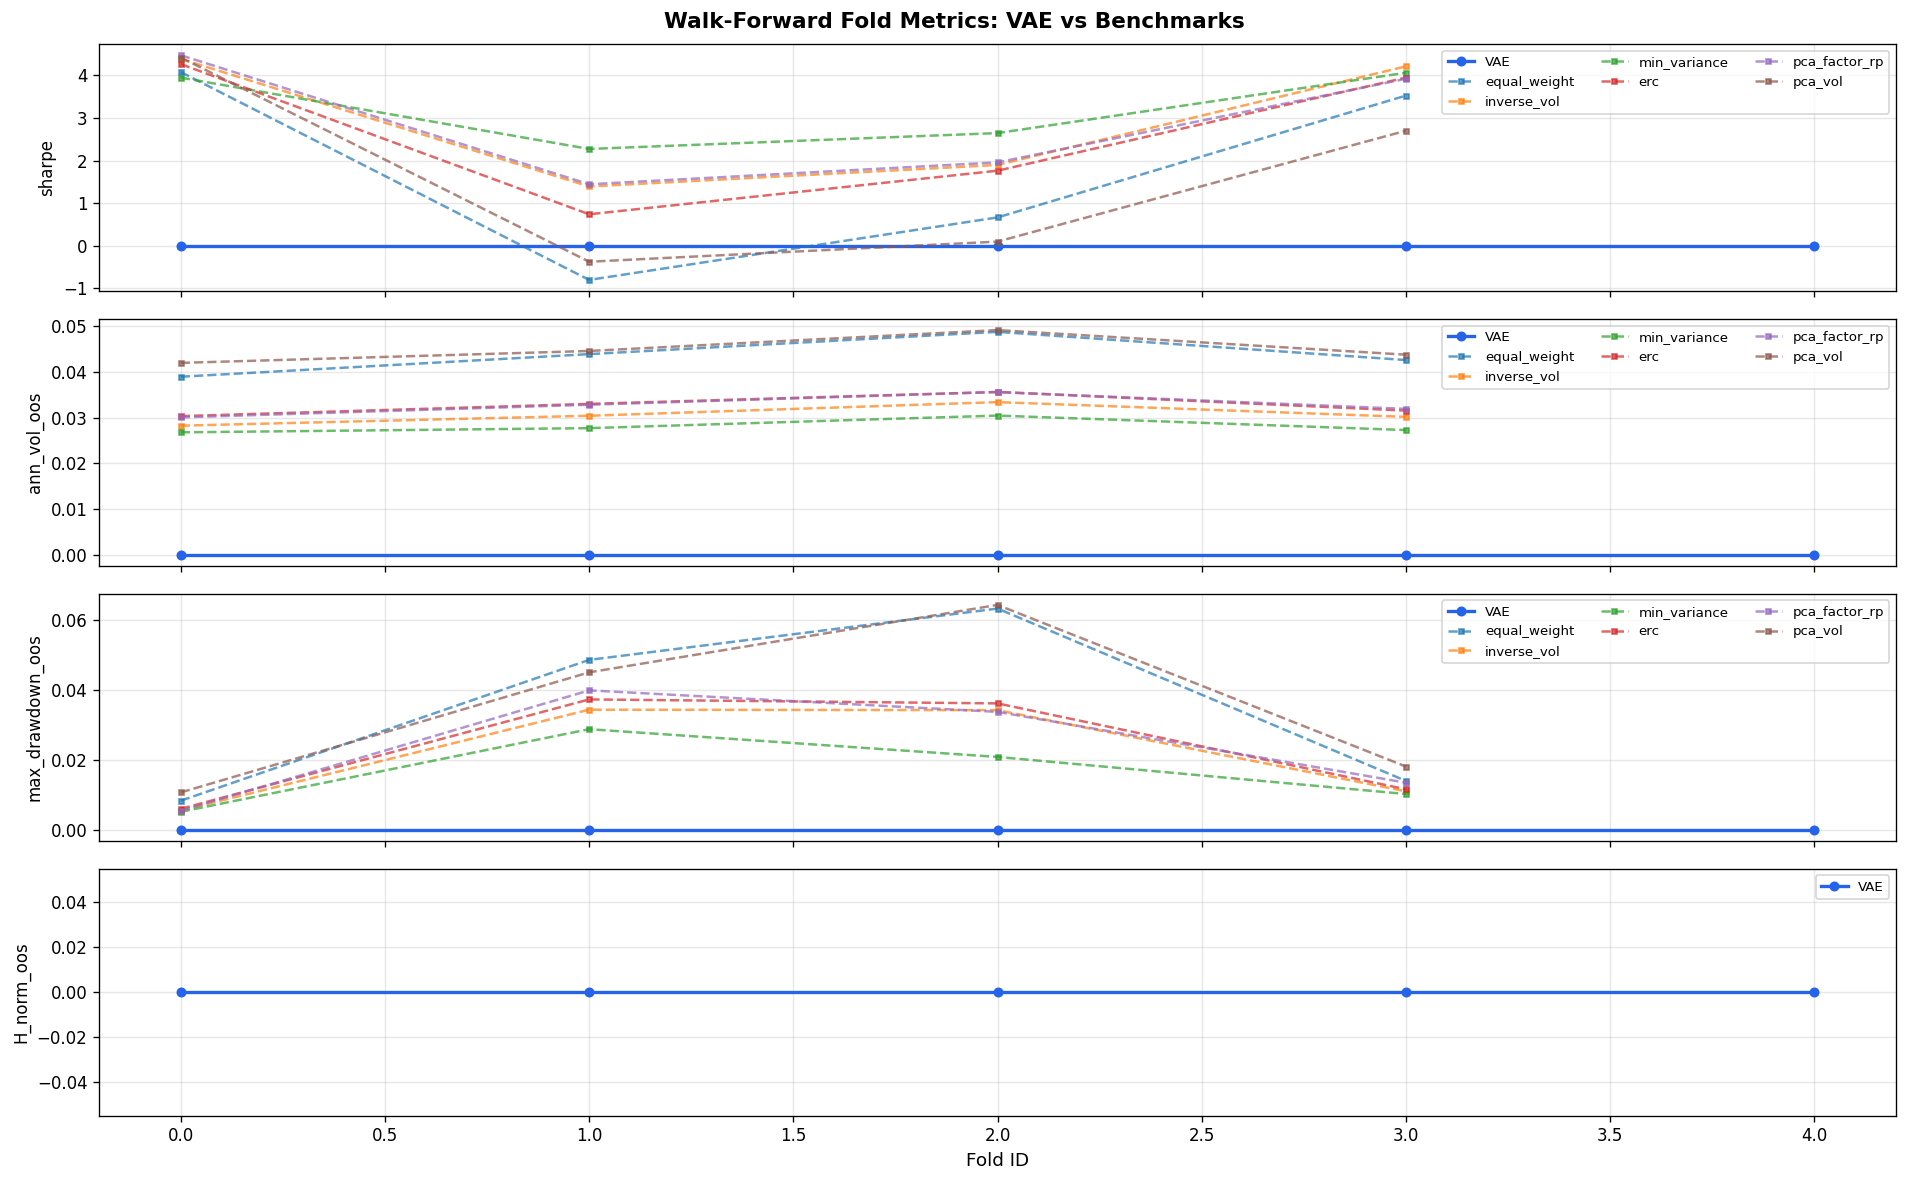

In [25]:
# Fold metrics: VAE vs benchmarks
plot_fold_metrics(results["vae_results"], results["benchmark_results"])
plt.show()

---
## 7. Results - Statistical Tests

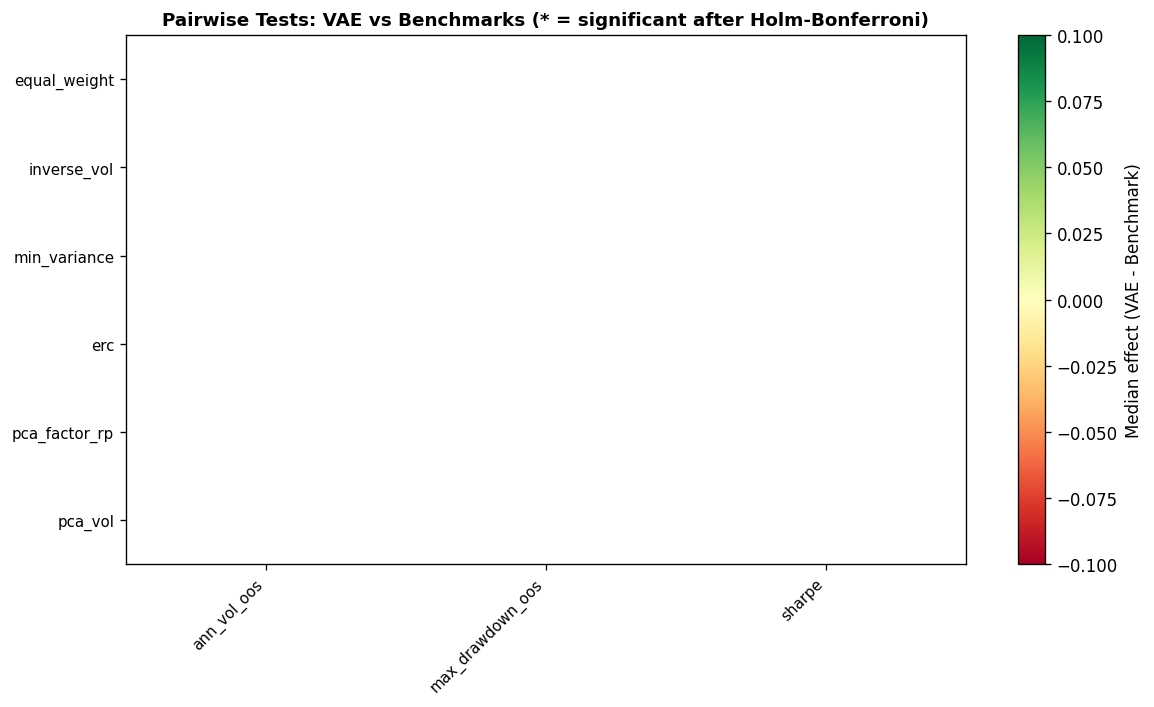

In [26]:
# Pairwise tests heatmap
plot_pairwise_heatmap(results["report"])
plt.show()

In [27]:
# Detailed pairwise test results
tests = results["report"]["statistical_tests"]
print(f"Total comparisons: {tests['n_tests']} (alpha={tests['alpha']})")
print()

for bench_name, metrics in tests["pairwise"].items():
    print(f"VAE vs {bench_name}:")
    for metric, result in metrics.items():
        if result.get("skipped", False):
            print(f"  {metric}: skipped ({result['reason']})")
            continue
        sig = " *" if result.get("significant_corrected", False) else ""
        print(f"  {metric}: delta={result['median_delta']:+.4f} "
              f"[{result['ci_lower']:+.4f}, {result['ci_upper']:+.4f}] "
              f"p={result.get('p_corrected', result['p_value']):.4f}{sig}")
    print()

Total comparisons: 0 (alpha=0.05)

VAE vs equal_weight:
  ann_vol_oos: skipped (Too few paired observations (4))
  max_drawdown_oos: skipped (Too few paired observations (4))
  sharpe: skipped (Too few paired observations (4))

VAE vs inverse_vol:
  ann_vol_oos: skipped (Too few paired observations (4))
  max_drawdown_oos: skipped (Too few paired observations (4))
  sharpe: skipped (Too few paired observations (4))

VAE vs min_variance:
  ann_vol_oos: skipped (Too few paired observations (4))
  max_drawdown_oos: skipped (Too few paired observations (4))
  sharpe: skipped (Too few paired observations (4))

VAE vs erc:
  ann_vol_oos: skipped (Too few paired observations (4))
  max_drawdown_oos: skipped (Too few paired observations (4))
  sharpe: skipped (Too few paired observations (4))

VAE vs pca_factor_rp:
  ann_vol_oos: skipped (Too few paired observations (4))
  max_drawdown_oos: skipped (Too few paired observations (4))
  sharpe: skipped (Too few paired observations (4))

VAE vs pc

---
## 8. Export Results

In [28]:
OUTPUT_DIR = "results/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Fold metrics CSV
vae_df.to_csv(os.path.join(OUTPUT_DIR, "vae_fold_metrics.csv"), index=False)

for bench_name, bench_metrics in results["benchmark_results"].items():
    bench_df = aggregate_fold_metrics(bench_metrics)
    bench_df.to_csv(os.path.join(OUTPUT_DIR, f"{bench_name}_fold_metrics.csv"), index=False)

# Text report
with open(os.path.join(OUTPUT_DIR, "report.txt"), "w") as f:
    f.write(format_summary_table(results["report"]))

# JSON report
with open(os.path.join(OUTPUT_DIR, "report.json"), "w") as f:
    json.dump(serialize_for_json(results["report"]), f, indent=2)

# Config snapshot
with open(os.path.join(OUTPUT_DIR, "config.json"), "w") as f:
    json.dump(serialize_for_json(asdict(config)), f, indent=2)

print(f"Results saved to {OUTPUT_DIR}")
print(f"  vae_fold_metrics.csv")
print(f"  <benchmark>_fold_metrics.csv (x{len(results['benchmark_results'])})")
print(f"  report.txt")
print(f"  report.json")
print(f"  config.json")

Results saved to results/
  vae_fold_metrics.csv
  <benchmark>_fold_metrics.csv (x6)
  report.txt
  report.json
  config.json
